# 期末大作业 使用BERT+ResNet

In [1]:
%pip install transformers torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import torch
import cv2
import random
from typing import List
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

## 数据读取与预处理

In [3]:
all_posters_filename = os.listdir('./poster')
all_posters_index = sorted([int(x[:-4]) for x in all_posters_filename])
all_posters_filename = [f'{i}.jpg' for i in all_posters_index]
df_movie_info = pd.read_csv('info.csv', index_col=0).loc[all_posters_index, ['name', 'intro']]
df_movie_info.head(5)

name  \
id                                        
1                     Toy Story (1995)    
2                       Jumanji (1995)    
3              Grumpier Old Men (1995)    
4             Waiting to Exhale (1995)    
5   Father of the Bride Part II (1995)    

                                                intro  
id                                                     
1   A cowboy doll is profoundly threatened and jea...  
2   When two kids find and play a magical board ga...  
3   John and Max resolve to save their beloved bai...  
4   Based on Terry McMillan's novel, this film fol...  
5   George Banks must deal not only with the pregn...

In [4]:
movie_intros = df_movie_info.loc[:, 'intro'].tolist()
movie_names = df_movie_info.loc[:, 'name'].tolist()

Le mépris (1963) 
Screenwriter Paul Javal's marriage to his wife Camille disintegrates during movie production as she spends time with the producer. Layered conflicts between art and business ensue.


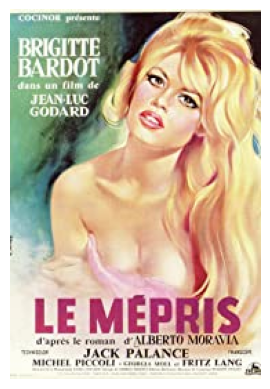

In [5]:
# 检查预处理完成后海报和简介数据的索引是否能够对应
index_for_test = random.randint(0, len(all_posters_index) - 1)

print(movie_names[index_for_test])
print(movie_intros[index_for_test])

poster = cv2.imread(f'./poster/{all_posters_filename[index_for_test]}')
poster = cv2.cvtColor(poster, cv2.COLOR_BGR2RGB)
plt.imshow(poster)
plt.axis('off')
plt.show()

## 训练集划分

In [6]:
with open('train.txt', 'r') as f:
    lines = f.readlines()
    train_idx = [int(line.strip()) for line in lines]

posters_train = [all_posters_filename[i] for i in train_idx]
posters_test = all_posters_filename.copy()
intros_train = [movie_intros[i] for i in train_idx]
intros_test = movie_intros.copy()

# Here elements in posters_train and posters_test are actually filenames, not vectors
print(len(posters_train), len(posters_test), len(intros_train), len(intros_test))

1762 2938 1762 2938


## 搭建pytorch数据集

以下只是一种可能的写法
- 如果之前已经完成了对海报和简介数据的预处理工作，那么就可以不需要这里的`process_poster`和`process_intro`函数
- 如果之前已经将海报数据全部读入，那么就无需再在`Dataset`类中写一次读取图片的操作（对于小数据集可以这样做，但是对于大型的数据集，全部读进来通常是存不下的，因此更推荐在继承的`Dataset`或者`DataLoader`中实现按需读取和预处理）
- ......

In [7]:
import torchvision.transforms as transforms
from torchvision import models
from sklearn.feature_extraction.text import TfidfVectorizer
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from transformers import ViTModel, ViTFeatureExtractor

cache_dir = './hub'
class MovieLensDataset(Dataset):
    def __init__(self, data_root, posters, intros, **kwargs):
        self.data_root = data_root
        self.posters = posters
        self.intros = intros
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', cache_dir=cache_dir)
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    
    def __len__(self):
        return len(self.posters)
    
    def process_poster(self, path):
        poster = cv2.imread(path)
        poster = cv2.cvtColor(poster, cv2.COLOR_BGR2RGB)
        poster = self.transform(poster)
        return poster
    
    
    def process_intro(self, intro):
        tokens = self.tokenizer(intro, padding='max_length', max_length=128, truncation=True, return_tensors='pt')
        return tokens['input_ids'].squeeze(0), tokens['attention_mask'].squeeze(0)
    
    def __getitem__(self, index):
        poster = self.process_poster(os.path.join(self.data_root, self.posters[index]))
        input_ids, attention_mask = self.process_intro(self.intros[index])
        return poster, input_ids, attention_mask


data_root = './poster'
dataset_train = MovieLensDataset(
    data_root=data_root,
    posters=posters_train,
    intros=intros_train,
)
dataset_test = MovieLensDataset(
    data_root=data_root,
    posters=posters_test,
    intros=intros_test,
)

/DATA/sqf/Miniconda/envs/gspl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
train_dataloader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=8)

In [9]:
import numpy as np

# 迭代DataLoader并查看数据
for posters, input_ids, attention_mask in train_dataloader:
    print("Intros:", input_ids)  # 打印简介文本
    print("intros shape:", input_ids.shape)
    print("Posters shape:", posters.shape)  # 打印海报张量的形状
    print("posters: ", posters)
    # 只查看一个批次
    break

Intros: tensor([[  101,  2117,  1999,  ...,     0,     0,     0],
        [  101,  2019,  4895,  ...,     0,     0,     0],
        [  101, 11888,  2989,  ...,     0,     0,     0],
        ...,
        [  101,  2043, 11122,  ...,     0,     0,     0],
        [  101,  1037,  6398,  ...,     0,     0,     0],
        [  101,  1037,  1000,  ...,     0,     0,     0]])
intros shape: torch.Size([32, 128])
Posters shape: torch.Size([32, 3, 224, 224])
posters:  tensor([[[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489]],

         [[ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286

## 定义模型

In [10]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics.pairwise import cosine_distances


class MyModel(nn.Module):
    def __init__(self, hidden_dim):
        super(MyModel, self).__init__()
        self.image_encoder = models.resnet50(pretrained=True)
        in_features = self.image_encoder.fc.in_features
        self.image_encoder.fc = nn.Identity()
        self.text_encoder = BertModel.from_pretrained('bert-base-uncased', cache_dir=cache_dir)
        self.image_fc = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.text_fc = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, images, input_ids, attention_mask):
        image_features = self.image_encoder(images)
        text_features = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        image_features = self.image_fc(image_features)
        text_features = self.text_fc(text_features)
        return image_features, text_features
    
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / temperature))

    def forward(self, image_features, text_features):
        batch_size = image_features.size(0)
        image_features = nn.functional.normalize(image_features, dim=1)
        text_features = nn.functional.normalize(text_features, dim=1)
        labels = torch.arange(batch_size).long().to(image_features.device)
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * torch.matmul(image_features, text_features.T)
        logits_per_text = logit_scale * torch.matmul(text_features, image_features.T)
        loss_i2t = nn.CrossEntropyLoss()(logits_per_image, labels)
        loss_t2i = nn.CrossEntropyLoss()(logits_per_text, labels)
        return (loss_i2t + loss_t2i) / 2
    
def compute_distance_matrix(image_features, text_features):
    image_features = nn.functional.normalize(image_features, dim=1)
    text_features = nn.functional.normalize(text_features, dim=1)
    distance_matrix = cosine_distances(image_features.detach().cpu().numpy(), text_features.detach().cpu().numpy())
    # print(distance_matrix.shape)
    return torch.tensor(distance_matrix, device=image_features.device)

def get_acc(D, ratio=0.05, dim=1):
    '''
    Calculate the accuracy based on the top-k nearest neighbors in the distance matrix.

    Parameters:
    D : torch.Tensor
        The distance matrix with shape (N, N), where 
        D[i, j] represents the distance between poster[i] and intro[j].
    ratio : float
        A float in the range (0, 1) that determines the proportion of nearest neighbors to consider. 
    dim : int
        The dimension along which to compute the top-k neighbors. 
        Use dim=1 for top-k intros for each poster, dim=0 for the top-k posters for each intro.
    '''

    total_samples = len(D)
    k = int(ratio * total_samples)

    _, topk_indices = D.topk(k, dim=dim, largest=False)
    if dim == 0:
        topk_indices = topk_indices.T
    
    correct_matches = 0
    for i in range(total_samples):
        if i in topk_indices[i]:
            correct_matches += 1
    accuracy = correct_matches / total_samples
    return accuracy

## 模型训练

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
hidden_dim = 256  # 隐藏层维度
model = MyModel(hidden_dim).to(device)
print(model)
criterion = NTXentLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

num_epochs = 70
best_acc =0.0
best_model_path = './bestmodel_resnet.pth'
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    
    for posters, input_ids, attention_mask in train_dataloader:
        posters, input_ids, attention_mask = posters.to(device), input_ids.to(device), attention_mask.to(device)
        
        image_features, text_features = model(posters, input_ids, attention_mask)
        
        loss = criterion(image_features, text_features)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    scheduler.step(epoch_loss / len(train_dataloader))
    
    # 计算距离矩阵和准确率
    model.eval()
    all_image_features = []
    all_text_features = []
    with torch.no_grad():
        for posters, input_ids, attention_mask in test_dataloader:
            posters, input_ids, attention_mask = posters.to(device), input_ids.to(device), attention_mask.to(device)
            image_features, text_features = model(posters, input_ids, attention_mask)
            all_image_features.append(image_features)
            all_text_features.append(text_features)
    
    # 拼接所有特征
    all_image_features = torch.cat(all_image_features, dim=0)
    all_text_features = torch.cat(all_text_features, dim=0)
    
    # 计算距离矩阵
    distance_matrix = compute_distance_matrix(all_image_features, all_text_features)
    acc_dim0 = get_acc(distance_matrix, ratio=0.05, dim=0)
    acc_dim1 = get_acc(distance_matrix, ratio=0.05, dim=1)
    
    avg_acc = (acc_dim0 + acc_dim1) / 2
    
    if avg_acc > best_acc:
        best_acc = avg_acc
        torch.save(model.state_dict(), best_model_path)
        print(f'Saved best model with accuracy: {best_acc * 100:.2f}%')
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_dataloader):.4f}, Accuracy Dim 0: {acc_dim0 * 100:.2f}%, Accuracy Dim 1: {acc_dim1 * 100:.2f}%')
print("Training finished!")

cuda


/DATA/sqf/Miniconda/envs/gspl/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/DATA/sqf/Miniconda/envs/gspl/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MyModel(
  (image_encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

## 模型测试

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_dim = 256
model = MyModel(hidden_dim).to(device)
best_model_path = './bestmodel_resnet.pth'
model.load_state_dict(torch.load(best_model_path))
model.eval()

all_image_features = []
all_text_features = []
with torch.no_grad():
    for posters, input_ids, attention_mask in test_dataloader:
        posters, input_ids, attention_mask = posters.to(device), input_ids.to(device), attention_mask.to(device)
        image_features, text_features = model(posters, input_ids, attention_mask)
        all_image_features.append(image_features)
        all_text_features.append(text_features)

all_image_features = torch.cat(all_image_features, dim=0)
all_text_features = torch.cat(all_text_features, dim=0)

distance_matrix = compute_distance_matrix(all_image_features, all_text_features)
acc_dim0 = get_acc(distance_matrix, ratio=0.05, dim=0)
acc_dim1 = get_acc(distance_matrix, ratio=0.05, dim=1)
sum_acc = acc_dim0 + acc_dim1
print(f'The acc of the best model is: acc_dim0: {acc_dim0} acc_dim1: {acc_dim1} sum: {sum_acc}')

The acc of the best model is: acc_dim0: 0.6606535057862492 acc_dim1: 0.6569094622191968 sum: 1.317562968005446


In [13]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


) missing from current font.l/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


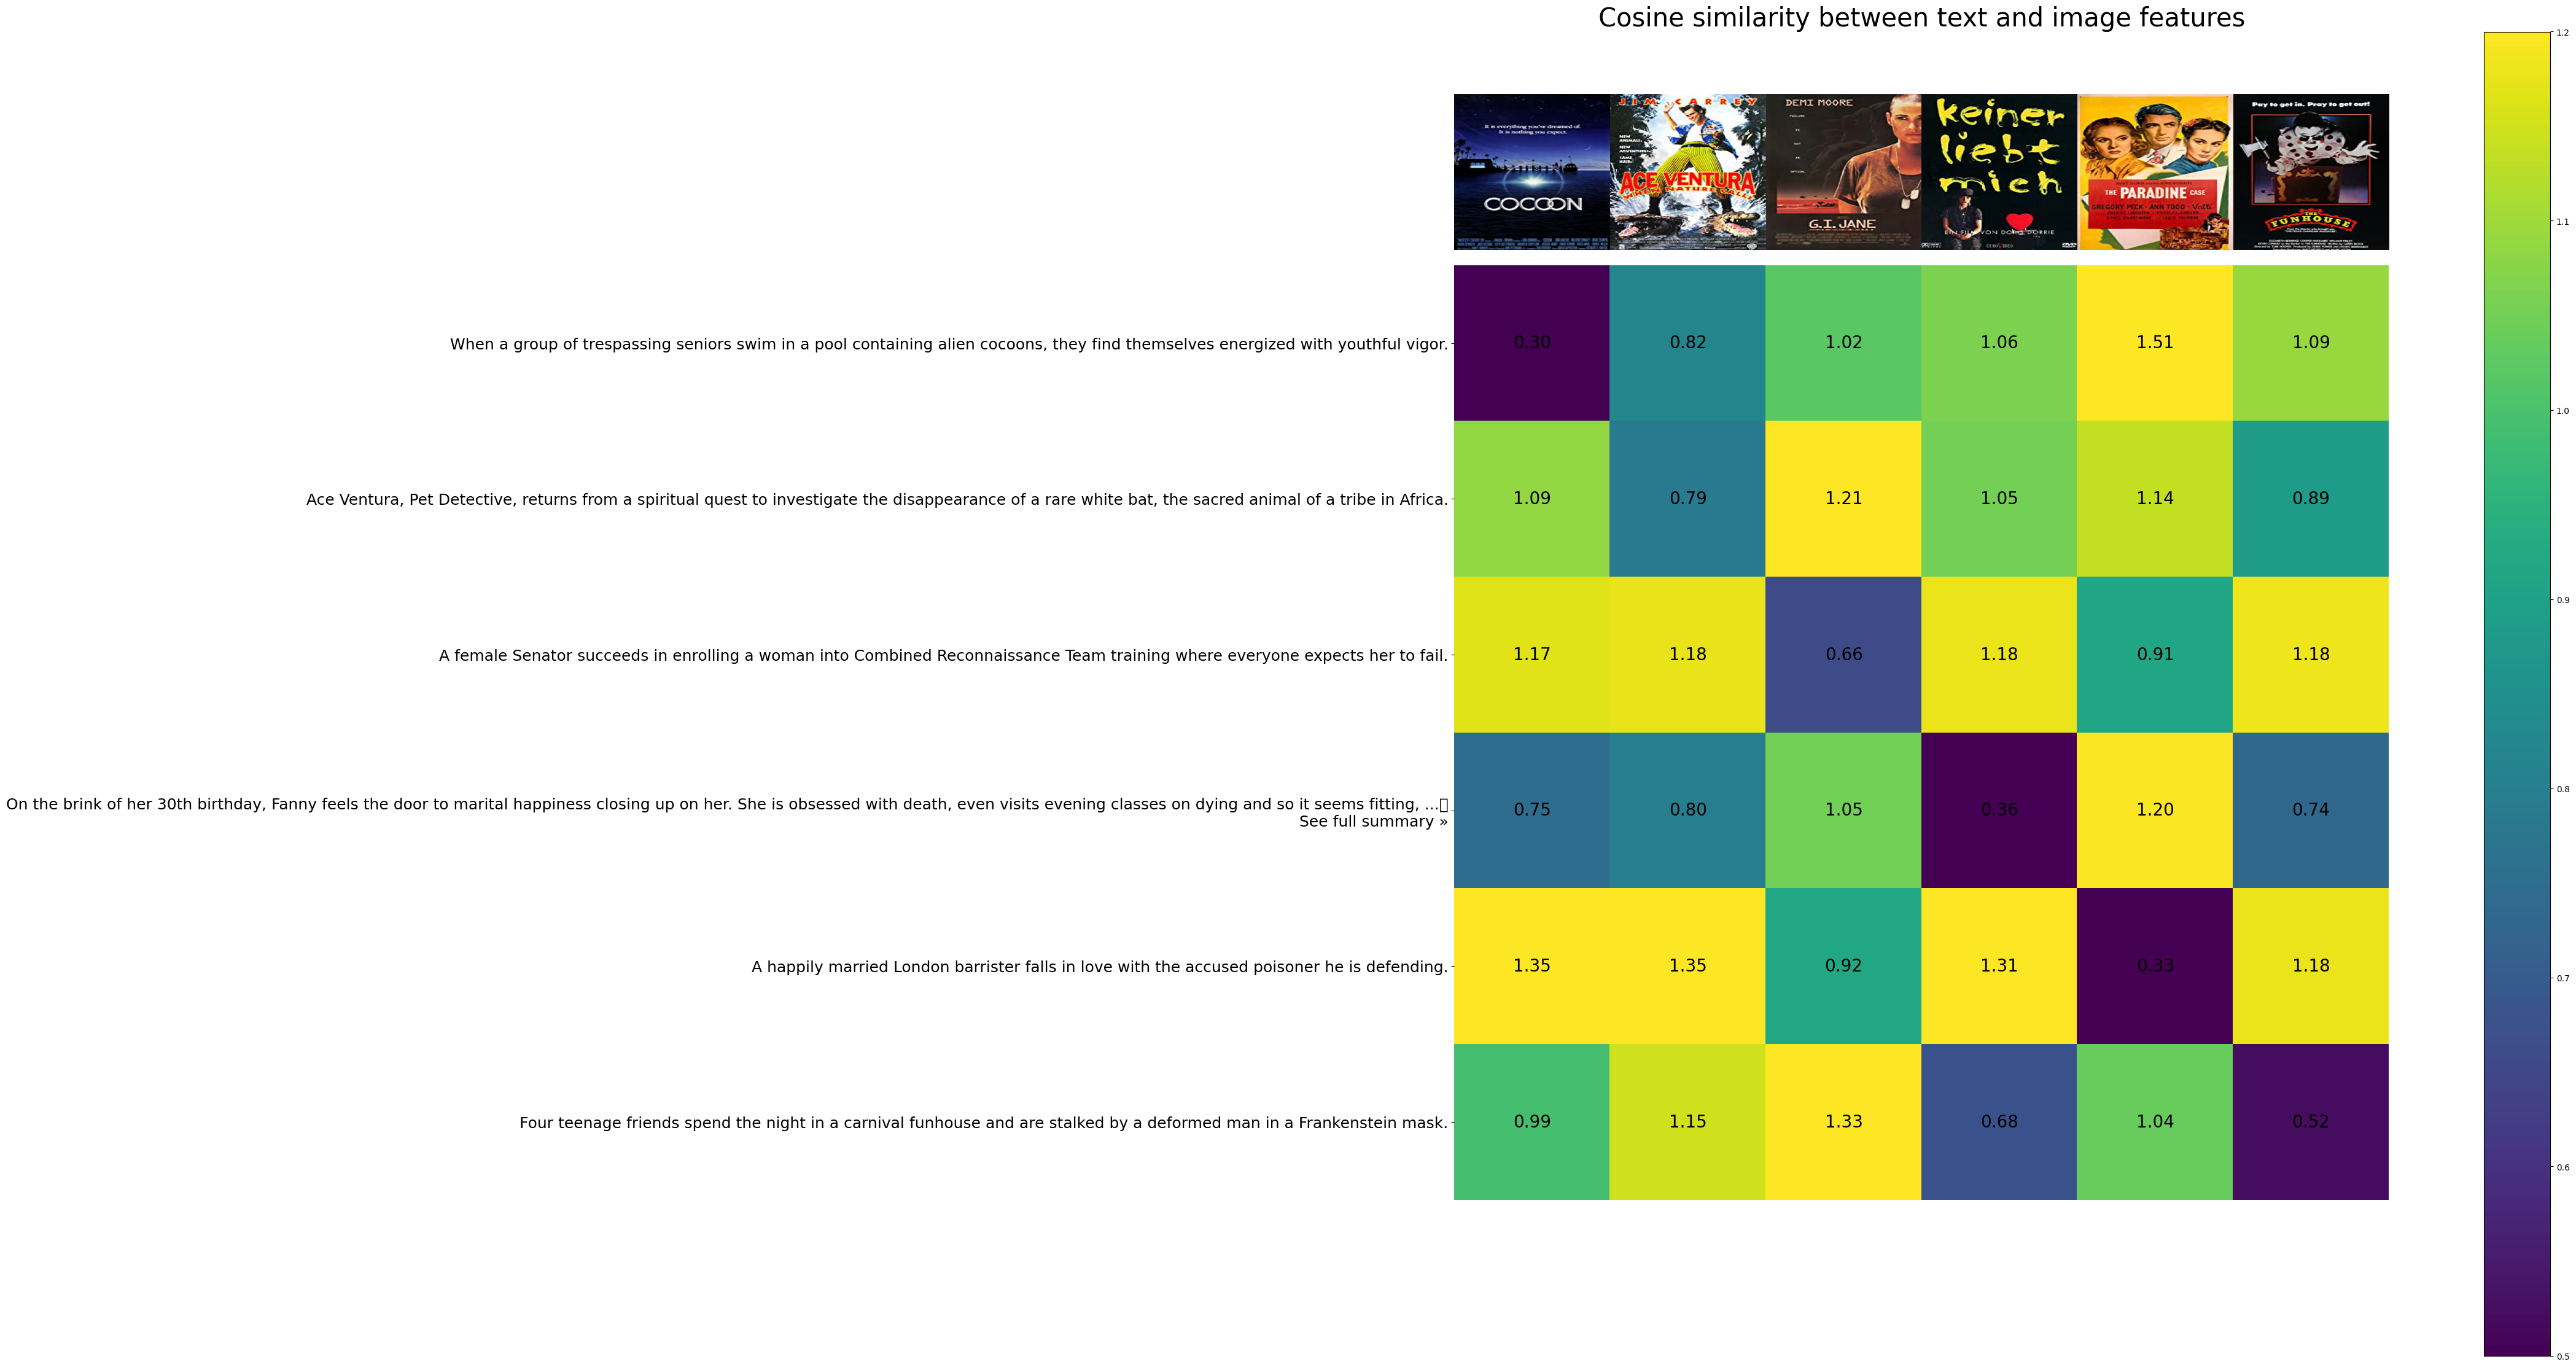

Movie Name: Cocoon (1985) 
Movie Intro: When a group of trespassing seniors swim in a pool containing alien cocoons, they find themselves energized with youthful vigor.


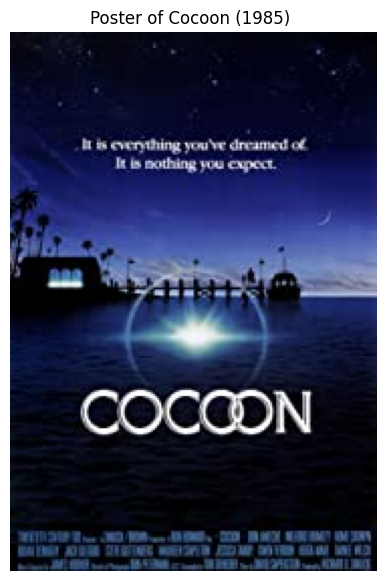

Movie Name: Ace Ventura: When Nature Calls (1995) 
Movie Intro: Ace Ventura, Pet Detective, returns from a spiritual quest to investigate the disappearance of a rare white bat, the sacred animal of a tribe in Africa.


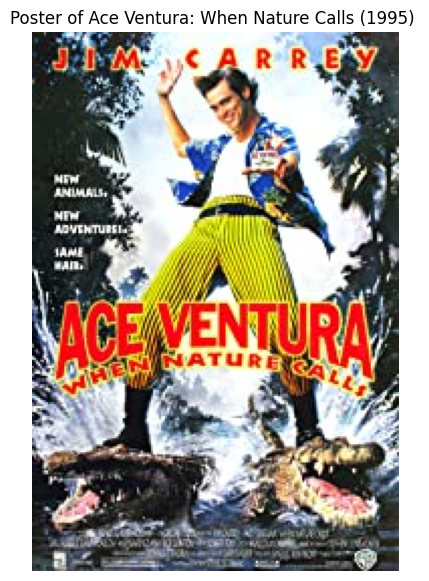

Movie Name: G.I. Jane (1997) 
Movie Intro: A female Senator succeeds in enrolling a woman into Combined Reconnaissance Team training where everyone expects her to fail.


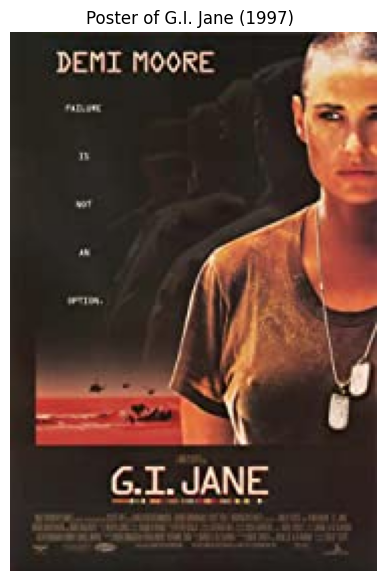

Movie Name: Keiner liebt mich (1994) 
Movie Intro: On the brink of her 30th birthday, Fanny feels the door to marital happiness closing up on her. She is obsessed with death, even visits evening classes on dying and so it seems fitting, ...
                    See full summary »


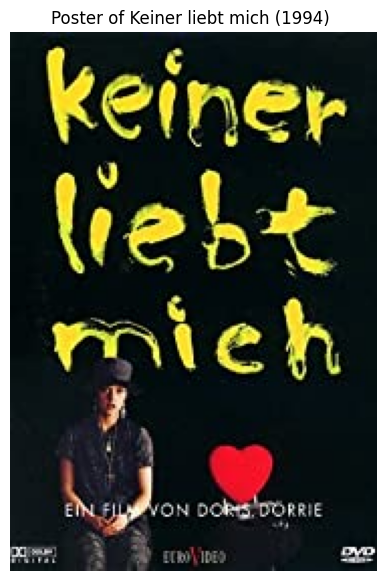

Movie Name: The Paradine Case (1947) 
Movie Intro: A happily married London barrister falls in love with the accused poisoner he is defending.


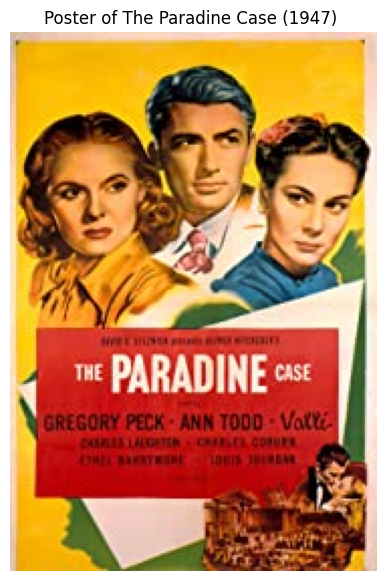

Movie Name: The Funhouse (1981) 
Movie Intro: Four teenage friends spend the night in a carnival funhouse and are stalked by a deformed man in a Frankenstein mask.


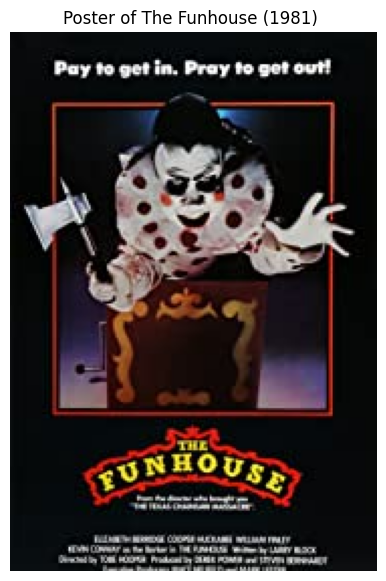

In [14]:
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

distance_matrix_np = distance_matrix.cpu().numpy()

selected_indices = random.sample(range(len(movie_names)), 6)
sub_distance_matrix = distance_matrix_np[selected_indices][:, selected_indices]

original_images = []
for index in selected_indices:
    filename = f'./poster/{all_posters_filename[index]}'
    image = Image.open(os.path.join(filename)).convert("RGB")
    original_images.append(image)

count = len(selected_indices)
texts = [movie_intros[i] for i in selected_indices]
plt.figure(figsize=(40, 28))
plt.imshow(sub_distance_matrix, vmin=0.5, vmax=1.2)
plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(sub_distance_matrix.shape[1]):
    for y in range(sub_distance_matrix.shape[0]):
        plt.text(x, y, f"{sub_distance_matrix[y, x]:.2f}", ha="center", va="center", size=20)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=30)
plt.show()

# 显示对应的海报图片和简介
for index in selected_indices:
    print("Movie Name:", movie_names[index])
    print("Movie Intro:", movie_intros[index])

    # 读取并显示对应的海报
    poster = cv2.imread(f'./poster/{all_posters_filename[index]}')
    poster = cv2.cvtColor(poster, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5, 7))
    plt.imshow(poster)
    plt.axis('off')
    plt.title(f"Poster of {movie_names[index]}")
    plt.show()


movie name: The Funhouse (1981) 
movie intro: Four teenage friends spend the night in a carnival funhouse and are stalked by a deformed man in a Frankenstein mask.


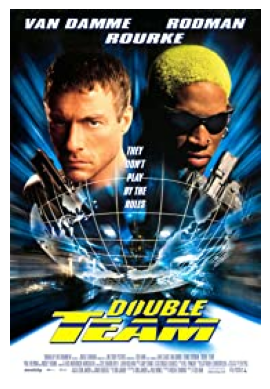

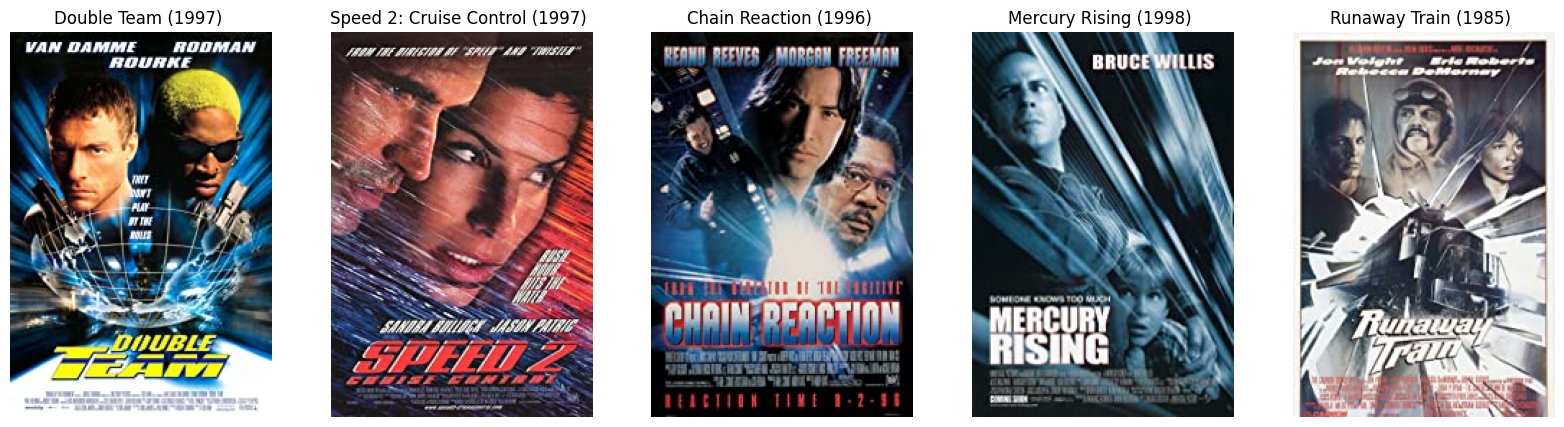

In [17]:
index_1 = random.randint(0, len(movie_names))
total_samples = len(distance_matrix)
_, topk_indices_1 = distance_matrix.topk(5, dim=1, largest=False)
print(f'movie name: {movie_names[index_1]}')
print(f'movie intro: {movie_intros[index_1]}')
poster = cv2.imread(f'./poster/{all_posters_filename[index_1]}')
poster = cv2.cvtColor(poster, cv2.COLOR_BGR2RGB)
plt.imshow(poster)
plt.axis('off')
plt.show()
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, ax in zip(topk_indices_1[index_1, :], axes):
    i = i.item()  # 将张量转换为整数
    poster = cv2.imread(f'./poster/{all_posters_filename[i]}')
    poster = cv2.cvtColor(poster, cv2.COLOR_BGR2RGB)
    ax.imshow(poster)
    ax.axis('off')
    ax.set_title(movie_names[i])

plt.show()

movie name: Germinal (1993) 
movie intro: In mid-nineteenth-century northern France, a coal mining town's workers are exploited by the mine's owner. One day, they decide to go on strike, and the authorities repress them.


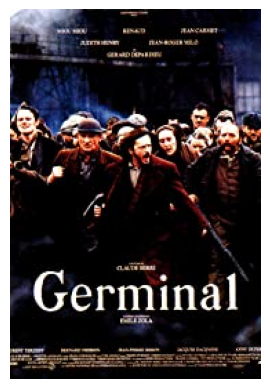

A group of professional bank robbers start to feel the heat from police when they unknowingly leave a clue at their latest heist.
Three years ago, entomologist Dr. Susan Tyler genetically created an insect to kill cockroaches carrying a virulent disease. Now, the insects are out to destroy their only predator, mankind.
The early life and career of Vito Corleone in 1920s New York City is portrayed, while his son, Michael, expands and tightens his grip on the family crime syndicate.
A soldier convicted for murdering his commanding officer is dumped and left to die on a prison island inhabited by two camps of convicts.
When tradition prevents her from marrying the man she loves, a young woman discovers she has a unique talent for cooking.


In [18]:
index = random.randint(0, len(movie_names))
total_samples = len(distance_matrix)
_, topk_indices_0 = distance_matrix.topk(5, dim=0, largest=False)
print(f'movie name: {movie_names[index]}')
print(f'movie intro: {movie_intros[index]}')
poster = cv2.imread(f'./poster/{all_posters_filename[index]}')
poster = cv2.cvtColor(poster, cv2.COLOR_BGR2RGB)
plt.imshow(poster)
plt.axis('off')
plt.show()
for i in topk_indices_0[:, index]:
    print(movie_intros[i])